# Linear Regression

In [1]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
import pandas as pd
from joblib import dump
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from sklearn.metrics import root_mean_squared_error

In [2]:
import sys
sys.path.append('F:\\Users\\Manuel García Plaza\\Desktop\\TFG\\')

In [3]:
from notebooks.utils.regression_metrics import regression

We load the data first. Then, we compute the models as we did in the House Prices notebook:

In [4]:
train =  pd.read_parquet('../../../data/model_input/train_sets/electricity_transformer.parquet')
validation =  pd.read_parquet('../../../data/model_input/validation_sets/electricity_transformer.parquet')

In [5]:
y_train = train.OT_next
X_train = train.drop(columns=['date', 'OT_next'])

In [6]:
y_validation = validation.OT_next
X_validation = validation.drop(columns=['date', 'OT_next'])

In [7]:
scaler = StandardScaler().fit(X_train, y_train)

In [9]:
X_train_scaled = scaler.transform(X_train)
X_validation_scaled = scaler.transform(X_validation)

In [16]:
lr = LinearRegression()
lr_l2 = Ridge()
lr_l1 = Lasso()
lr_en1 = ElasticNet(l1_ratio=0.25)
lr_en2 = ElasticNet(l1_ratio=0.5)
lr_en3 = ElasticNet(l1_ratio=0.75)

In [17]:
models_list = [lr, lr_l2, lr_l1, lr_en1, lr_en2 , lr_en3]
names_list = ['LR', 'LR_l2', 'LR_l1', 'LR_en_0.25', 'LR_en_0.5', 'LR_en_0.75']

In [18]:
metrics = regression(models_list, names_list, '../../../data/metrics/electricity_transformer/linear_regression.csv', X_train_scaled, y_train, X_validation_scaled, y_validation)
metrics

,Run_Time,Train_RMSE,Validation_RMSE,delta%
LR,1.245193,0.481326,0.293664,-38.988584
LR_l2,0.110704,0.481344,0.294367,-38.844841
LR_l1,0.162564,1.113313,1.566715,40.725461
LR_en_0.25,8.505532,1.335146,0.891685,-33.214417
LR_en_0.5,5.504353,1.353771,1.162898,-14.099371
LR_en_0.75,5.060011,1.327091,1.410177,6.260711


Almost every model works  better in the validation than in the train. We are gonig to choose **LR** as the best model. Let's check if it still performing that well in the test:

In [19]:
test =  pd.read_parquet('../../../data/model_input/test_sets/electricity_transformer.parquet')

In [20]:
y_test = test.OT_next
X_test = test.drop(columns=['date', 'OT_next'])

In [21]:
retrain = pd.concat([train, validation])

In [22]:
y_retrain = retrain.OT_next
X_retrain = retrain.drop(columns=['date', 'OT_next'])

In [23]:
scaler_retrain = StandardScaler().fit(X_retrain, y_retrain)

In [24]:
X_retrain_scaled = scaler_retrain.transform(X_retrain)
X_test_scaled = scaler_retrain.transform(X_test)

In [25]:
model = LinearRegression().fit(X_retrain_scaled, y_retrain)

In [26]:
test_pred = model.predict(X_test_scaled)
rmse = root_mean_squared_error(y_test, test_pred)
print('Test RMSE:', round(rmse, 4))

Test RMSE: 0.3264


We still having a model which performs well, then keep going

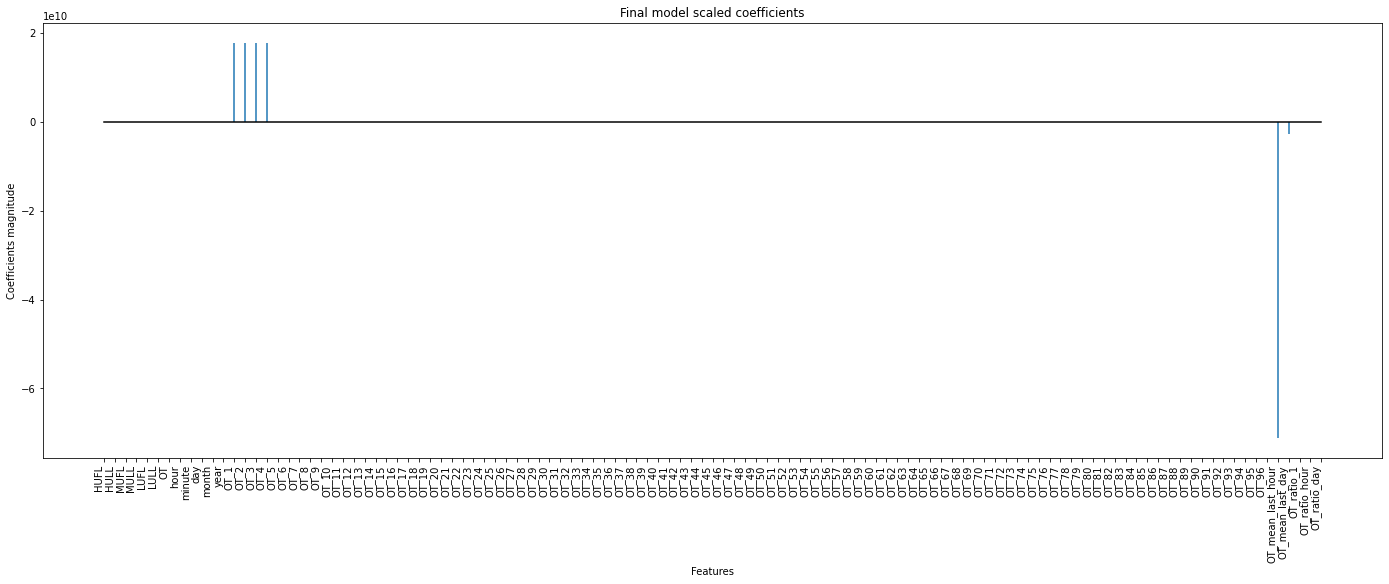

In [27]:
fig, ax = plt.subplots(figsize=(24, 8))
ax.stem(X_retrain.columns, model.coef_.ravel(), markerfmt=' ', basefmt='k-')
plt.xticks(rotation=90, ha='right')
ax.set_xlabel('Features')
ax.set_ylabel('Coefficients magnitude')
ax.set_title('Final model scaled coefficients');

In [28]:
dump(model, 'best_linear_regression.joblib')

['best_linear_regression.joblib']

In [29]:
with open('../../../data/metrics/electricity_transformer/final_RMSE.txt', 'a') as f:
    f.write('\nLR, '+ str(rmse))

## Residuals diagnosis

C:\Users\MANUEL~2\AppData\Local\Temp/ipykernel_16460/2975082643.py:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  axes[0, 0].plot([y_retrain.min(), y_retrain.max()], [y_retrain.min(), y_retrain.max()],
C:\aaa\lib\site-packages\statsmodels\graphics\gofplots.py:1045: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


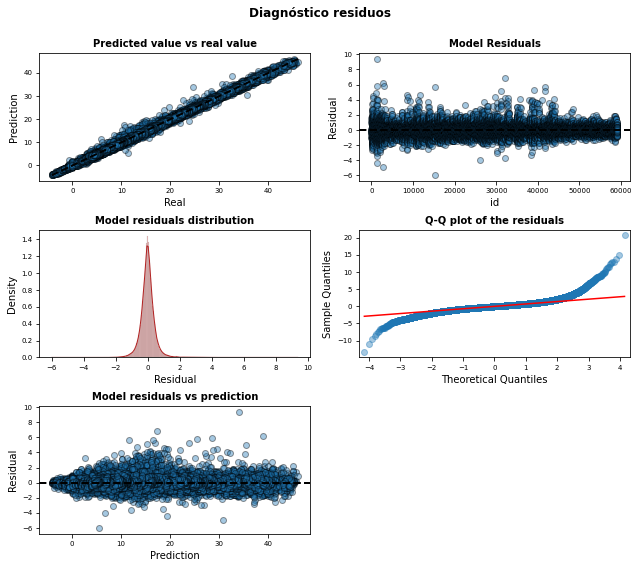

In [30]:
prediction_retrain = model.predict(X_retrain_scaled)
error_retrain   = prediction_retrain - y_retrain

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(9, 8))

axes[0, 0].scatter(y_retrain, prediction_retrain, edgecolors=(0, 0, 0), alpha = 0.4)
axes[0, 0].plot([y_retrain.min(), y_retrain.max()], [y_retrain.min(), y_retrain.max()],
                'k--', color = 'black', lw=2)
axes[0, 0].set_title('Predicted value vs real value', fontsize = 10, fontweight = "bold")
axes[0, 0].set_xlabel('Real')
axes[0, 0].set_ylabel('Prediction')
axes[0, 0].tick_params(labelsize = 7)

axes[0, 1].scatter(list(range(len(y_retrain))), error_retrain,
                   edgecolors=(0, 0, 0), alpha = 0.4)
axes[0, 1].axhline(y = 0, linestyle = '--', color = 'black', lw=2)
axes[0, 1].set_title('Model Residuals', fontsize = 10, fontweight = "bold")
axes[0, 1].set_xlabel('id')
axes[0, 1].set_ylabel('Residual')
axes[0, 1].tick_params(labelsize = 7)

sns.histplot(
    data    = error_retrain,
    stat    = "density",
    kde     = True,
    line_kws= {'linewidth': 1},
    color   = "firebrick",
    alpha   = 0.3,
    ax      = axes[1, 0]
)

axes[1, 0].set_title('Model residuals distribution', fontsize = 10,
                     fontweight = "bold")
axes[1, 0].set_xlabel("Residual")
axes[1, 0].tick_params(labelsize = 7)


sm.qqplot(
    error_retrain,
    fit   = True,
    line  = 'q',
    ax    = axes[1, 1], 
    color = 'firebrick',
    alpha = 0.4,
    lw    = 2
)
axes[1, 1].set_title('Q-Q plot of the residuals', fontsize = 10, fontweight = "bold")
axes[1, 1].tick_params(labelsize = 7)

axes[2, 0].scatter(prediction_retrain, error_retrain,
                   edgecolors=(0, 0, 0), alpha = 0.4)
axes[2, 0].axhline(y = 0, linestyle = '--', color = 'black', lw=2)
axes[2, 0].set_title('Model residuals vs prediction', fontsize = 10, fontweight = "bold")
axes[2, 0].set_xlabel('Prediction')
axes[2, 0].set_ylabel('Residual')
axes[2, 0].tick_params(labelsize = 7)

# Se eliminan los axes vacíos
fig.delaxes(axes[2,1])

fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Diagnóstico residuos', fontsize = 12, fontweight = "bold");

This model looks quite reliable, residuals are normally distributed except for extreme values.